<a href="https://colab.research.google.com/github/SoniaBorsi/Adversarial-Attack-GNN/blob/metattack/metattack_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [ ]:
# !pip uninstall -y torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv deeprobust
'''
If import block fails with a numpy size diff, uncomment and run the two lines below. rerun all blocks after.
'''
#!pip uninstall -y numpy
#!pip install numpy==1.23.5

In [ ]:
!pip install numpy==1.23.5 torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install deeprobust
!pip install networkx matplotlib
!pip install ogb

In [4]:
# Import the required modules
import torch
import torch_geometric
import deeprobust

print("PyTorch Version:", torch.__version__)
print("PyG Installed:", torch_geometric.__version__)

import torch.nn.functional as F
import numpy as np

print("Numpy Installed:", np.__version__)

import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sparse

PyTorch Version: 2.0.0+cu117
PyG Installed: 2.6.1
Numpy Installed: 1.23.5


In [5]:
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_scipy_sparse_matrix, subgraph
from torch_geometric.data import Data
from torch_sparse import from_scipy

from deeprobust.graph.global_attack import Metattack
print("Metattack Imported Successfully")

# Planetoid: Cora, Citeseer, PubMed
# WebKB: Texas
# PolBlogs: polblogs
# Flickr: Flickr
from torch_geometric.datasets import Planetoid, WebKB, PolBlogs, Flickr
# OGB: ogbn-proteins
from ogb.nodeproppred import PygNodePropPredDataset

Metattack Imported Successfully


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load Datasets
Cora, Citeseer, PubMed, Texas, PolBlogs, and Flickr

In [ ]:
'''
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
import os

def subset_graph(data, num_nodes_subset, save_path):
  #Make a subset of a graph if it is too big
  perm = torch.randperm(data.num_nodes)[:num_nodes_subset]
  perm = perm.sort()[0]

  edge_index, _ = subgraph(perm, data.edge_index, relabel_nodes=True)

  x = data.x[perm] if data.x is not None else None
  y = data.y[perm] if data.y is not None else None

  new_data = Data(x=x, edge_index=edge_index, y=y)
  torch.save(new_data, save_path)
  print(f"Saved subset graph to {save_path}")
  return new_data
'''

In [ ]:
# Still failing because using all RAM
'''
import random

def subsample(data, num_nodes):
  node_indices = torch.randperm(data.num_nodes)[:num_nodes]
  edge_index, _ = subgraph(node_indices, data.edge_index, relabel_nodes=True)
  data.x = data.x[node_indices]
  data.y = data.y[node_indices]

  # (Re)define masks
  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.train_mask[:int(0.6 * num_nodes)] = True

  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True

  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.test_mask[int(0.8 * num_nodes):] = True

  data.edge_index = edge_index
  return data
'''

In [ ]:
# Still failing because uses all RAM

'''
def subsample_ogbn_proteins(dataset, num_nodes=7000):
  full_data = dataset[0]
  sampled_nodes = torch.randperm(full_data.num_nodes)[:num_nodes]

  edge_index, edge_mask = subgraph(sampled_nodes, full_data.edge_index, relabel_nodes=True)
  edge_attr = full_data.edge_attr[edge_mask]

  # Simulate node features if missing
  x = torch.zeros((num_nodes, 1))

  # Subsample y
  y = full_data.y[sampled_nodes]

  # Generate new train/val/test masks
  train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  test_mask = torch.zeros(num_nodes, dtype=torch.bool)

  train_mask[:int(0.6 * num_nodes)] = True
  val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True
  test_mask[int(0.8 * num_nodes):] = True

  return Data(
      x=x,
      edge_index=edge_index,
      edge_attr=edge_attr,
      y=y,
      train_mask=train_mask,
      val_mask=val_mask,
      test_mask=test_mask,
  )
'''

In [ ]:

def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    data = Planetoid(root=f"./data/{name}", name=name)[0]
  elif name == "Texas":
    data = WebKB(root=f"./data/{name}", name=name)[0]
  elif name == "PolBlogs":
    data = PolBlogs(root=f"./tmp/polblogs")[0]
  elif name == "ogbn-proteins":
    data = PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")[0]
  elif name == "Flickr":
    data = Flickr(root=f"./data/Flickr")[0]
  else:
    raise ValueError("Dataset not found")

  return data

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "ogbn-proteins": load_dataset("ogbn-proteins"),
    "Flickr": load_dataset("Flickr")
}

# Load datasets for all datasets when using ogbn-proteins, flickr, and pubmed
'''
def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    data = Planetoid(root=f"./data/{name}", name=name)[0]

    if name == "PubMed":
      data = subsample(data, 5000)
    return data

  elif name == "Texas":
    return WebKB(root=f"./data/{name}", name=name)[0]
  elif name == "PolBlogs":
   return PolBlogs(root=f"./tmp/polblogs")[0]
  elif name == "ogbn-proteins":
    dataset = PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")
    return subsample_ogbn_proteins(dataset, num_nodes=7000)

  elif name == "Flickr":
    data = Flickr(root=f"./data/Flickr")[0]
    return subsample(data, 5000)
  else:
    raise ValueError("Dataset not found")

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "ogbn-proteins": load_dataset("ogbn-proteins"),
    "Flickr": load_dataset("Flickr")
}
'''

# Define GCN Model

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.gc1 = GCNConv(num_features, hidden_channels).to(device)
        self.gc2 = GCNConv(hidden_channels, num_classes).to(device)

        self.nfeat = num_features
        self.nclass = num_classes
        self.hidden_sizes = [hidden_channels]
        self.with_relu = True

    @property
    def gc1_weight(self):
        return self.gc1.lin.weight

    @property
    def gc2_weight(self):
        return self.gc2.lin.weight

    @property
    def weight(self):
        return self.gc1.lin.weight

    def forward(self, x, edge_index):
        x = self.gc1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gc2(x, edge_index)
        self.output = x
        return x

# Train GCN Model

In [21]:
def train_model(model, data, epochs=100, lr=0.01, weight_decay=5e-4):
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.y = data.y.to(device)
    data.train_mask = data.train_mask.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')

    return model


# Metattack Over All Datasets

In [49]:
def apply_metattack(model, data, num_perturbations):
  device = data.x.device
  model_cpu = model.to("cpu")

  # Convert adjacency matrix and features to sparse format
  adj = to_scipy_sparse_matrix(data.edge_index.cpu(), num_nodes=data.num_nodes).tocsr()
  features = sparse.csr_matrix(data.x.cpu().numpy())
  labels = data.y.cpu()

  # Get train and unlabeled indices
  idx_train = data.train_mask.nonzero(as_tuple=True)[0].cpu().numpy()
  idx_unlabeled = (~data.train_mask).nonzero(as_tuple=True)[0].cpu().numpy()

  # Initialize Metattack
  attacker = Metattack(
      model=model,
      nnodes=data.num_nodes,
      attack_structure=True,
      attack_features=False,
      device='cpu'
  )

  # Perform attack
  attacker.attack(
      features,
      adj,
      labels,
      idx_train,
      idx_unlabeled,
      n_perturbations=num_perturbations,
      ll_constraint=False  # This avoids the sparse tensor issue
  )

  # Ensure `modified_adj` and `modified_features` exist and return them
  attacker.modified_adj = torch.tensor(attacker.modified_adj.toarray(), dtype=torch.float).to(device)

  modified_features = (
    torch.tensor(attacker.modified_features.toarray(), dtype=torch.float).to(device)
    if attacker.modified_features is not None
    else data.x.to(device)
  )

  data.y = data.y.to(device)

  return attacker.modified_adj, attacker.modified_features

# Evaluate Model

In [14]:
def evaluate_model(model, data, perturbed_adj, perturbed_features):
  # Check the type of perturbed_adj
  #print(f"perturbed_adj type: {type(perturbed_adj)}")

  # Ensure the adjacency matrix is in sparse COO format
  if not perturbed_adj.is_sparse:
        perturbed_adj = perturbed_adj.to_sparse()

  # Get edge_index directly from the sparse tensor (COO format)
  edge_index = perturbed_adj._indices().to(device)

  # Use original features if perturbed ones are not returned
  if perturbed_features is None:
        perturbed_x = data.x.to(device)
  else:
      if hasattr(perturbed_features.to(device), "toarray"):
          perturbed_x = torch.tensor(perturbed_features.toarray(), dtype=torch.float).to(device)
      else:
          perturbed_x = perturbed_features.to(device)

  # Forward pass through the model using the perturbed graph and features
  model.eval()
  with torch.no_grad():
        out = model(perturbed_x, edge_index)

  # Ensure test_mask is correctly sized and boolean
  if data.test_mask.shape[0] != data.num_nodes:
    print(f"Adjusting test_mask size for {data.dataset_name}...")
    # Truncate or adjust the size
    data.test_mask = data.test_mask[:data.num_nodes]

  # Flatten test_mask if it's not 1D
  if len(data.test_mask.shape) > 1:
      data.test_mask = data.test_mask.flatten()

  data.y = data.y.to(device)
  # Ensure data.test_mask has the correct size and is boolean
  data.test_mask = data.test_mask[:data.num_nodes].to(torch.bool).to(device)

  #if len(data.test_mask.shape) == 1:
    # Ensure it is boolean
    #data.test_mask = data.test_mask.to(torch.bool)

  # Check the shapes of predictions and ground truth labels
  print(f"Prediction shape: {out.shape}")
  print(f"test_mask shape: {data.test_mask.shape}")
  print(f"Ground truth labels shape: {data.y.shape}")

  # Ensure data.y has the same size as test_mask
  assert data.y.shape[0] == data.num_nodes, "data.y shape mismatch with num_nodes"

  # Compute accuracy
  pred = out.argmax(dim=1)
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().to(device).item()
  acc = correct / data.test_mask.sum().to(device).item()

  return acc

# Visualization

In [51]:
def visualize_graph(edge_index, title="Graph"):
  if isinstance(edge_index, torch.Tensor):
    edge_index = edge_index.cpu().numpy()

  if edge_index.shape[0] != 2:
    raise ValueError("Expected edge_index shape [2, num_edges]")

  # Convert to list of edge tuples
  edge_list = list(zip(edge_index[0], edge_index[1]))

  G = nx.Graph()
  G.add_edges_from(edge_list)
  plt.figure(figsize=(8, 6))
  nx.draw(G, node_size=30, edge_color="gray", alpha=0.6, with_labels=False)
  plt.title(title)
  plt.show()

# Create Masks

In [16]:
def split_masks(data, train_ratio=0.6, val_ratio=0.2):
  num_nodes = data.num_nodes
  indices = torch.randperm(num_nodes, device=device)

  train_size = int(train_ratio * num_nodes)
  val_size = int(val_ratio * num_nodes)

  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)
  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool, device=device)

  data.train_mask[indices[:train_size]] = True
  data.val_mask[indices[train_size:train_size + val_size]] = True
  data.test_mask[indices[train_size + val_size:]] = True

  return data

# Run Experiments

In [17]:
# TODO: make num_perturbations 0.2 * number of edges (once initial experiments run)

def run_experiment(dataset_name):
  dataset = load_dataset(dataset_name)

  if isinstance(dataset, Data):
    # Already a Data object
    data = dataset
  else:
    # Dataset is a list-like object (like Planetoid)
    data = dataset[0]

  if data.x is None:
    # Patching missing features (for PolBlogs, speficially)
    # All zero-features carry no useful info -> poor performance,
    # so each node has a unique identifier (one-hot encoding). GNN can differentiate them based on graph structure + node identity
    print(f"{dataset_name} patching missing features...")
    data.x = torch.eye(data.num_nodes)

  # Check the shape of the masks and labels BEFORE: debug
  #print(f"train_mask shape: {data.train_mask.shape}")
  #print(f"data.y shape: {data.y.shape}")

  if not hasattr(data, 'train_mask') or data.train_mask.shape[0] != data.num_nodes:
    # dataset that doesnt come with masks ie. built-in train/test/val splits
    print(f"{dataset_name} making masks...")
    data = split_masks(data)
  else:
    if len(data.train_mask.shape) > 1:
      # If the train_mask exists but is not 1D, fix it to be
      print(f"Fixing train_mask_shape for {dataset_name}...")
      data.train_mask = data.train_mask.view(-1)

  # check train_mask is correct (Texas)
  if data.train_mask.shape[0] != data.num_nodes:
    print(f"Adjusting train_masks size for {dataset_name}...")
    # Truncate or adjust the size
    data.train_mask = data.train_mask[:data.num_nodes]
  if len(data.train_mask.shape) == 1:
    # Ensure it is boolean
    data.train_mask = data.train_mask.to(torch.bool)

  # Check the shape of the masks and labels AFTER: debug
  #print(f"train_mask shape: {data.train_mask.shape}")
  #print(f"data.y shape: {data.y.shape}")

  num_classes = len(torch.unique(data.y))

  print("=" * 100)
  print(f"Dataset: {dataset_name}\n")
  print(f"Number of nodes: {data.num_nodes}")
  print(f"Number of features: {data.num_features}")
  print(f"Number of classes: {num_classes}\n")

  # Move data masks and features to GPU
  data.train_mask = data.train_mask.to(device)
  data.test_mask = data.test_mask.to(device)
  data.y = data.y.to(device)

  model = GCN(data.num_features, 16, num_classes).to(device)
  model = train_model(model, data)

  if data.num_nodes <= 5000:
    print("-" * 100)
    print("Original Graph")
    visualize_graph(data.edge_index, title=f"{dataset_name}: Before Metattack")

  num_perturbations = int(data.edge_index.size(1) * 0.01)
  print(f"Running on {num_perturbations} perturbations")
  # TODO: make num_perturbations 0.2 * number of edges once initial experiments run
  perturbed_adj, perturbed_features = apply_metattack(model, data, num_perturbations=num_perturbations)
  edge_index_perturbed = perturbed_adj.nonzero().t().to(device)

  if data.num_nodes <= 5000:
    print("-" * 100)
    print("Perturbed Graph")
    visualize_graph(edge_index_perturbed, title=f"{dataset_name}: After Metattack")

  acc = evaluate_model(model, data, perturbed_adj, perturbed_features)
  print(f"Accuracy after Metattack on {dataset_name}: {acc:.4f}")


# Execution

Dataset: Cora

Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Epoch 0, Loss: 1.9428
Epoch 10, Loss: 0.7221
Epoch 20, Loss: 0.2481
Epoch 30, Loss: 0.1077
Epoch 40, Loss: 0.0648
Epoch 50, Loss: 0.0527
Epoch 60, Loss: 0.0386
Epoch 70, Loss: 0.0400
Epoch 80, Loss: 0.0376
Epoch 90, Loss: 0.0391
----------------------------------------------------------------------------------------------------
Original Graph


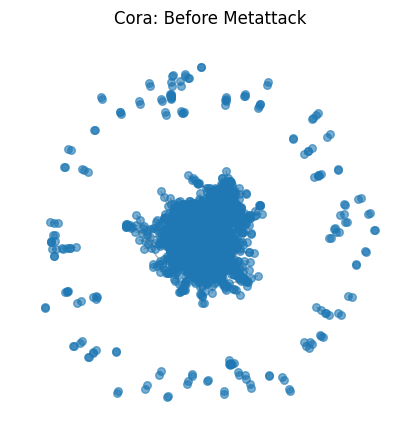

Running on 105 perturbations


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [50]:
# all datasets, uncomment when debugged all
#datasets = ["Cora", "Citeseer", "PolBlogs", "Texas", "Flickr", "PubMed", "ogbn-proteins"]

# Base code these datasets run
datasets = ["Cora", "Citeseer", "PolBlogs", "Texas"]
# These datasets crash - reason: too big, use all available RAM
#datasets = [ "ogbn-proteins", "Flickr", "PubMed"]

for dataset_name in datasets:
  run_experiment(dataset_name)